In [2]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
# 시계열 data split
from sklearn.model_selection import TimeSeriesSplit
# timeseriessplit 시각화
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
# 모델
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')

In [4]:
# timeseriessplit 시각화용 함수
def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

In [6]:
# blocked TimeSeriesSplit 용 class 정의
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# training 데이터 셋 만들기

## 1. gens : 실제 발전량 ( y로 쓸 예정 ) 
## 2. p_gens : 모델별 발전량 ( x변수로 추가 할 예정 )
## 3. wf : 기상 예측량 ( x변수로 추가 할 예정 )

In [7]:
gens = pd.read_csv("../gens.csv")
p_gens = pd.read_csv("../pred.csv")
wf = pd.read_csv("../weather_forecast.csv")

## 날씨 예측을 10시에 한번 17시에 한번 진행 함으로 2개로 나눠야함.

In [8]:
# 날씨 예측량을 round1,2로 분리함
wf_round1 = wf[wf["round"]==1]
wf_round2 = wf[wf["round"]==2]

## p_gens를 x변수로 만들기 위해서 모델별로 분리

In [9]:
# 발전량 예측량을 모델별로 분리해서 변수로 만들라고 분리하는거
# round1에 대해 진행할 경우에 이거 실행
p_gens0 = p_gens.loc[(p_gens["model_id"]==0) & (p_gens["round"]==1)].reset_index()
p_gens1 = p_gens.loc[(p_gens["model_id"]==1) & (p_gens["round"]==1)].reset_index()
p_gens2 = p_gens.loc[(p_gens["model_id"]==2) & (p_gens["round"]==1)].reset_index()
p_gens3 = p_gens.loc[(p_gens["model_id"]==3) & (p_gens["round"]==1)].reset_index()
p_gens4 = p_gens.loc[(p_gens["model_id"]==4) & (p_gens["round"]==1)].reset_index()


In [10]:
# 발전량 예측량을 모델별로 분리해서 변수로 만들라고 분리하는거
# round2에 대해 진행할 경우에 이거 실행
p_gens0 = p_gens.loc[(p_gens["model_id"]==0) & (p_gens["round"]==2)].reset_index()
p_gens1 = p_gens.loc[(p_gens["model_id"]==1) & (p_gens["round"]==2)].reset_index()
p_gens2 = p_gens.loc[(p_gens["model_id"]==2) & (p_gens["round"]==2)].reset_index()
p_gens3 = p_gens.loc[(p_gens["model_id"]==3) & (p_gens["round"]==2)].reset_index()
p_gens4 = p_gens.loc[(p_gens["model_id"]==4) & (p_gens["round"]==2)].reset_index()

## p_gens 변수로 만들어진 데이터 셋, wf로 만든 데이터셋을 통합해야함. 시간을 기준으로 통합 예정

In [11]:
# p_gens(모델 예측량) 데이터 프레임 생성
x_df = pd.DataFrame({"m0": p_gens0["amount"],"m1": p_gens1["amount"],
              "m2": p_gens2["amount"],"m3": p_gens3["amount"],
              "time" : p_gens0["time"]})

In [12]:
# time을 기준으로 두 데이터 병합 ( p_gens, wf )
# 1차 모델링의 Y값으로 쓰일 발전량 gens도 같이 병합
# round2에 대해 수행해야하면 wf_round2/ 아니면 wf_round1
xy_df = pd.merge(x_df,wf_round1,on="time")
xy_df = pd.merge(xy_df,gens,on="time")

# 월과 날짜 변수를 추가 할 것임, 또한 시간대를 기준으로 데이터프레임을 3개 생성해야함으로 hour 변수도 추가
xy_df["time"]=pd.to_datetime(xy_df["time"])
xy_df["month"]=xy_df["time"].dt.month
xy_df["day"]=xy_df["time"].dt.day
xy_df["hour"]=xy_df["time"].dt.hour


In [13]:
# 시간에 따라 전체 통합된 데이터셋을 3개로 분리
# 7-10, 11-14 , 15-19
xy_df_1 = xy_df[(xy_df["hour"]<=10) & (xy_df["hour"]>=7)]
xy_df_2 = xy_df[(xy_df["hour"]<=15) & (xy_df["hour"]>=11)]
xy_df_3 = xy_df[(xy_df["hour"]<=19) & (xy_df["hour"]>=16)]

In [14]:
xy_df_2

,m0,m1,m2,m3,time,round,cloud,temp,humidity,ground_press,...,snow,dew_point,vis,uv_idx,azimuth,elevation,amount,month,day,hour
10,41.4121,47.8090,45.8966,31.5627,2022-06-19 11:00:00+09:00,1,100.0,21.51,89.0,1008.0,...,0.0,18.3333,16.0934,5.0,112.342,66.4014,59.0,6,19,11
11,56.4874,54.4961,51.5485,43.3967,2022-06-19 12:00:00+09:00,1,88.0,22.34,84.0,1008.0,...,0.0,18.3333,16.0934,11.0,143.612,76.3123,55.0,6,19,12
12,60.1034,57.5034,57.3383,50.6172,2022-06-19 13:00:00+09:00,1,72.0,23.17,81.0,1007.0,...,0.0,17.7778,16.0934,11.0,207.104,77.4400,65.0,6,19,13
13,57.0286,58.1305,62.8745,54.1898,2022-06-19 14:00:00+09:00,1,67.0,23.89,78.0,1006.0,...,0.0,18.8889,16.0934,8.0,244.082,68.3532,46.0,6,19,14
14,55.8605,58.2186,62.5869,50.1150,2022-06-19 15:00:00+09:00,1,56.0,24.34,76.0,1006.0,...,0.0,18.3333,16.0934,5.0,259.989,56.6154,41.0,6,19,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11578,57.8762,59.3476,52.5556,55.5518,2023-10-15 11:00:00+09:00,1,12.0,18.98,68.0,1013.0,...,0.0,12.7778,16.0934,4.0,152.542,42.9224,54.0,10,15,11
11579,60.4846,63.2077,52.5277,58.5800,2023-10-15 12:00:00+09:00,1,10.0,19.20,67.0,1013.0,...,0.0,12.7778,16.0934,4.0,172.860,46.6011,51.0,10,15,12
11580,61.0122,66.6243,52.7246,64.0328,2023-10-15 13:00:00+09:00,1,8.0,19.37,67.0,1013.0,...,0.0,13.3333,16.0934,4.0,194.339,45.8045,82.0,10,15,13
11581,62.4748,63.3071,49.9163,63.1707,2023-10-15 14:00:00+09:00,1,10.0,19.47,68.0,1012.0,...,0.0,13.3333,16.0934,3.0,213.572,40.7522,45.0,10,15,14


## 클러스터링 시작

### 패널 형식으로 만들어야함

In [15]:
ts_ary = xy_df_2.copy()
ts_ary["time"] = pd.to_datetime(ts_ary["time"])
ts_ary["year"] = ts_ary["time"].dt.year
ts_ary["month"] = ts_ary["time"].dt.month
ts_ary["hour"] = ts_ary["time"].dt.hour
ts_ary

,m0,m1,m2,m3,time,round,cloud,temp,humidity,ground_press,...,dew_point,vis,uv_idx,azimuth,elevation,amount,month,day,hour,year
10,41.4121,47.8090,45.8966,31.5627,2022-06-19 11:00:00+09:00,1,100.0,21.51,89.0,1008.0,...,18.3333,16.0934,5.0,112.342,66.4014,59.0,6,19,11,2022
11,56.4874,54.4961,51.5485,43.3967,2022-06-19 12:00:00+09:00,1,88.0,22.34,84.0,1008.0,...,18.3333,16.0934,11.0,143.612,76.3123,55.0,6,19,12,2022
12,60.1034,57.5034,57.3383,50.6172,2022-06-19 13:00:00+09:00,1,72.0,23.17,81.0,1007.0,...,17.7778,16.0934,11.0,207.104,77.4400,65.0,6,19,13,2022
13,57.0286,58.1305,62.8745,54.1898,2022-06-19 14:00:00+09:00,1,67.0,23.89,78.0,1006.0,...,18.8889,16.0934,8.0,244.082,68.3532,46.0,6,19,14,2022
14,55.8605,58.2186,62.5869,50.1150,2022-06-19 15:00:00+09:00,1,56.0,24.34,76.0,1006.0,...,18.3333,16.0934,5.0,259.989,56.6154,41.0,6,19,15,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11578,57.8762,59.3476,52.5556,55.5518,2023-10-15 11:00:00+09:00,1,12.0,18.98,68.0,1013.0,...,12.7778,16.0934,4.0,152.542,42.9224,54.0,10,15,11,2023
11579,60.4846,63.2077,52.5277,58.5800,2023-10-15 12:00:00+09:00,1,10.0,19.20,67.0,1013.0,...,12.7778,16.0934,4.0,172.860,46.6011,51.0,10,15,12,2023
11580,61.0122,66.6243,52.7246,64.0328,2023-10-15 13:00:00+09:00,1,8.0,19.37,67.0,1013.0,...,13.3333,16.0934,4.0,194.339,45.8045,82.0,10,15,13,2023
11581,62.4748,63.3071,49.9163,63.1707,2023-10-15 14:00:00+09:00,1,10.0,19.47,68.0,1012.0,...,13.3333,16.0934,3.0,213.572,40.7522,45.0,10,15,14,2023


In [16]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

In [17]:
ts_ary = ts_ary[ts_ary["month"].isin([9,10,11])]
ts_ary = ts_ary[ts_ary["hour"].isin([11,12,13,14,15])]

In [18]:
h = 0
t = 5
st_array = []
for i in range(0,136):
    st = np.array(ts_ary["amount"][h:t])
    st = st.reshape(-1,1)
    st_array.append(st)
    h+=5
    t+=5
    
res = np.stack(st_array,axis=0)



C:\Users\admin\AppData\Local\Temp\ipykernel_14348\785207643.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  st = np.array(ts_ary["amount"][h:t])


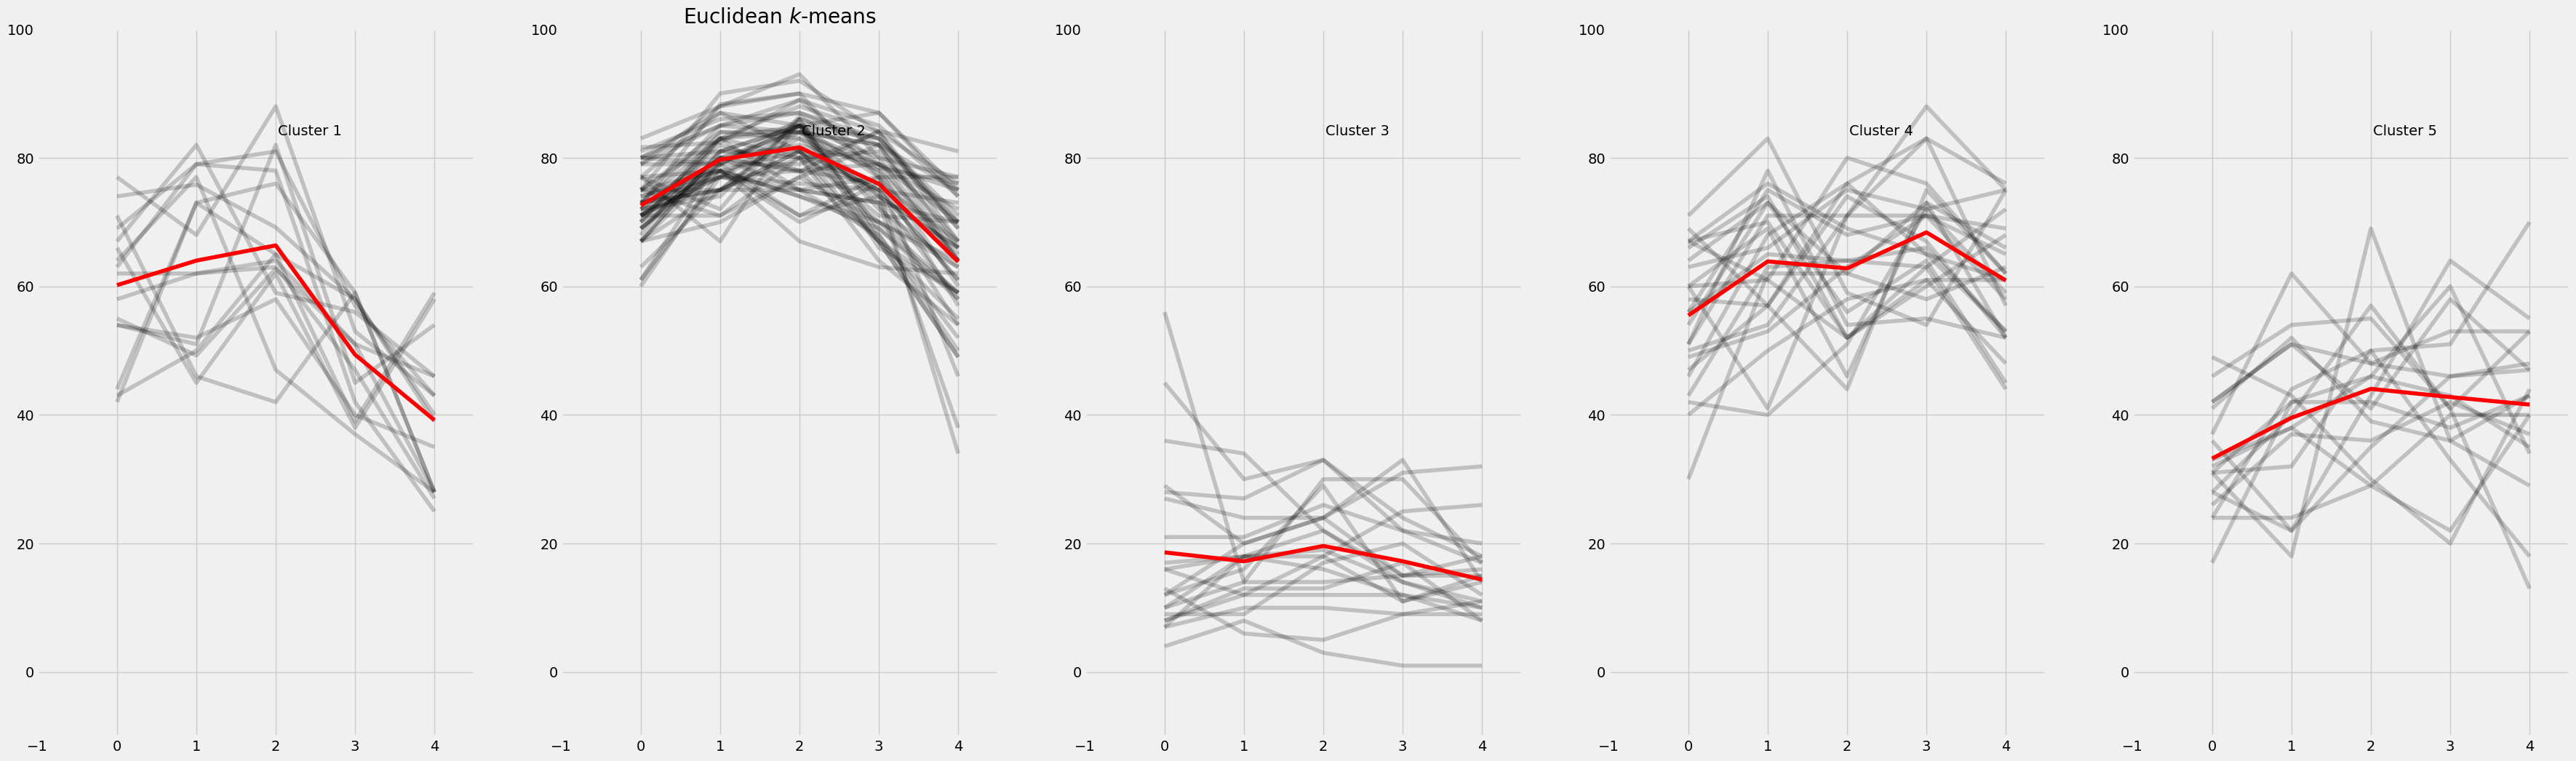

In [19]:
km = TimeSeriesKMeans(n_clusters=5, verbose=False, random_state=42, n_jobs=-1,metric="euclidean")
y_pred = km.fit_predict(res)

plt.figure(figsize=(40,12))
for yi in range(5):
    plt.subplot(1, 5, yi + 1)
    for xx in res[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(-1, 4.5)
    plt.ylim(-10, 100)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

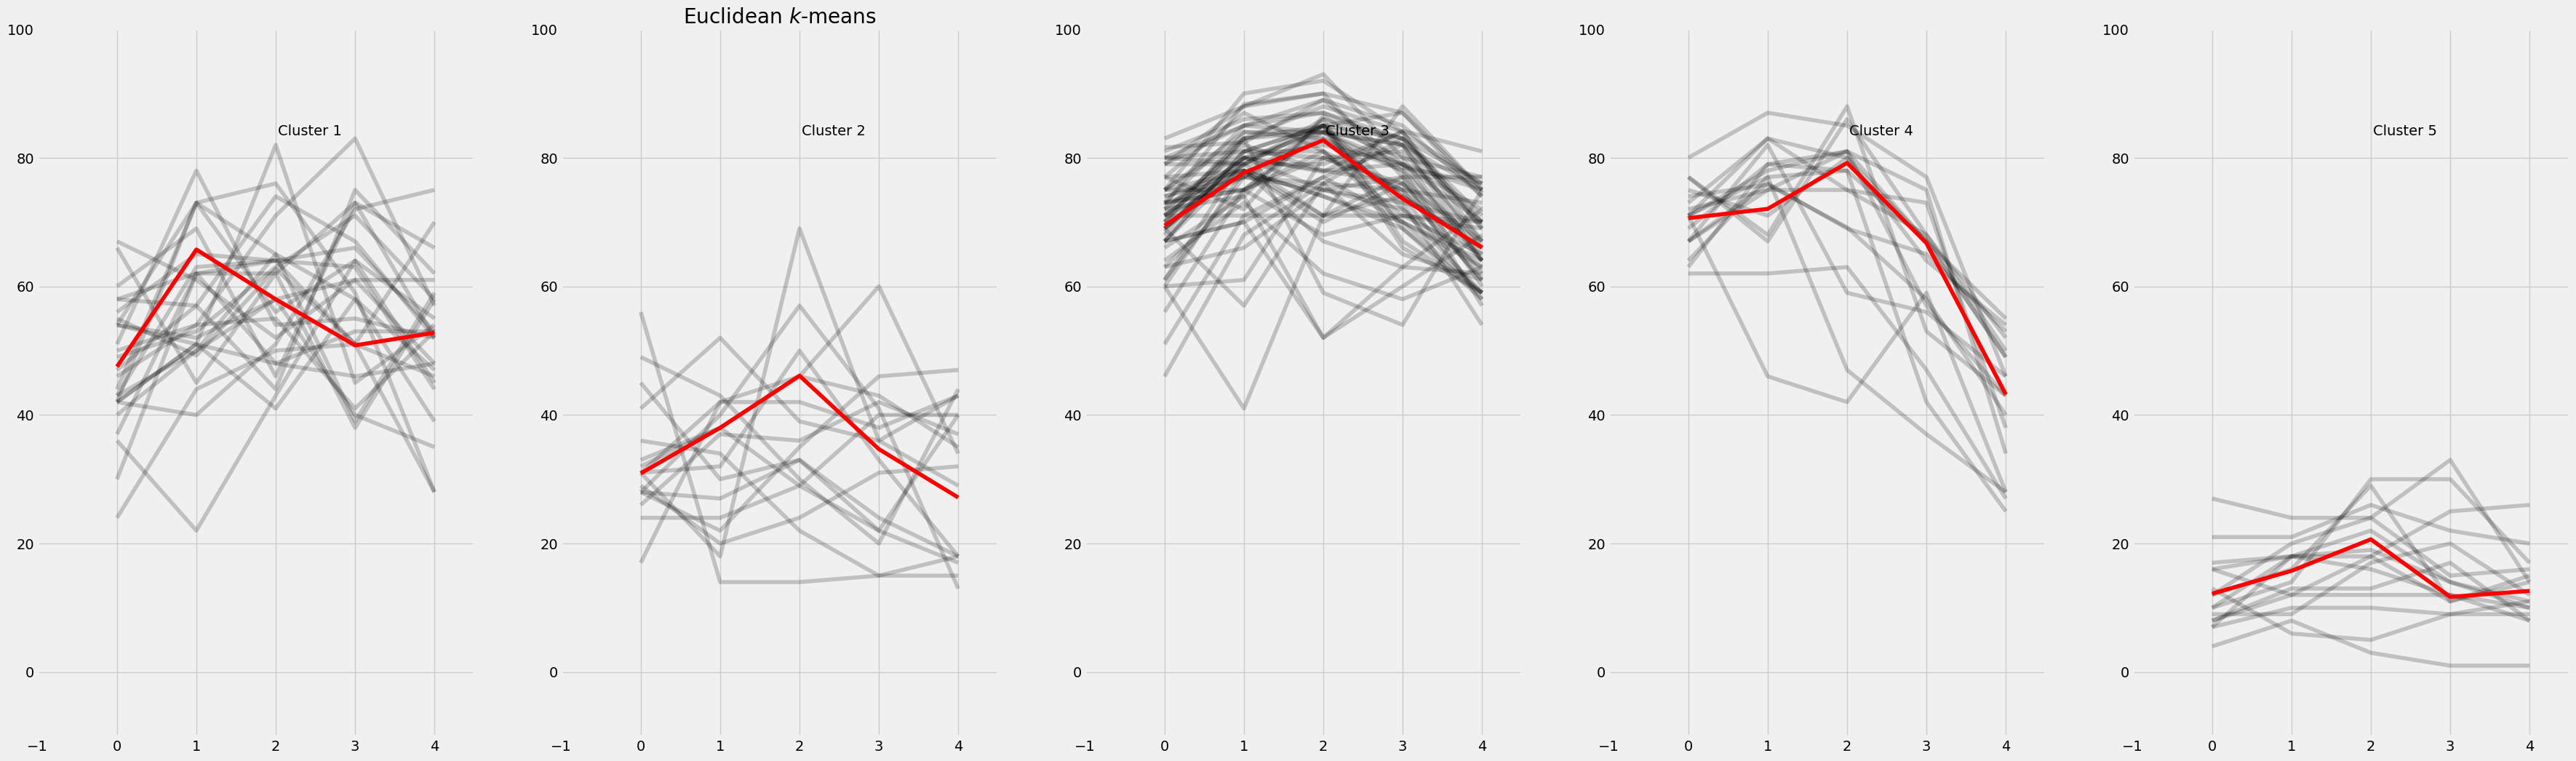

In [100]:
km = TimeSeriesKMeans(n_clusters=5, verbose=False, random_state=42, n_jobs=-1,metric="dtw")
y_pred = km.fit_predict(res)

plt.figure(figsize=(40,12))
for yi in range(5):
    plt.subplot(1, 5, yi + 1)
    for xx in res[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(-1, 4.5)
    plt.ylim(-10, 100)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

### 클러스터 열 추가

In [20]:
idx_list = np.repeat(y_pred,5)
ts_ary["cluster"] = idx_list

### 상관계수 확인

C:\Users\admin\AppData\Local\Temp\ipykernel_14348\4225053671.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(ts_ary.query("cluster==1").corr(),annot=True, annot_kws={"size": 10})


<AxesSubplot: >

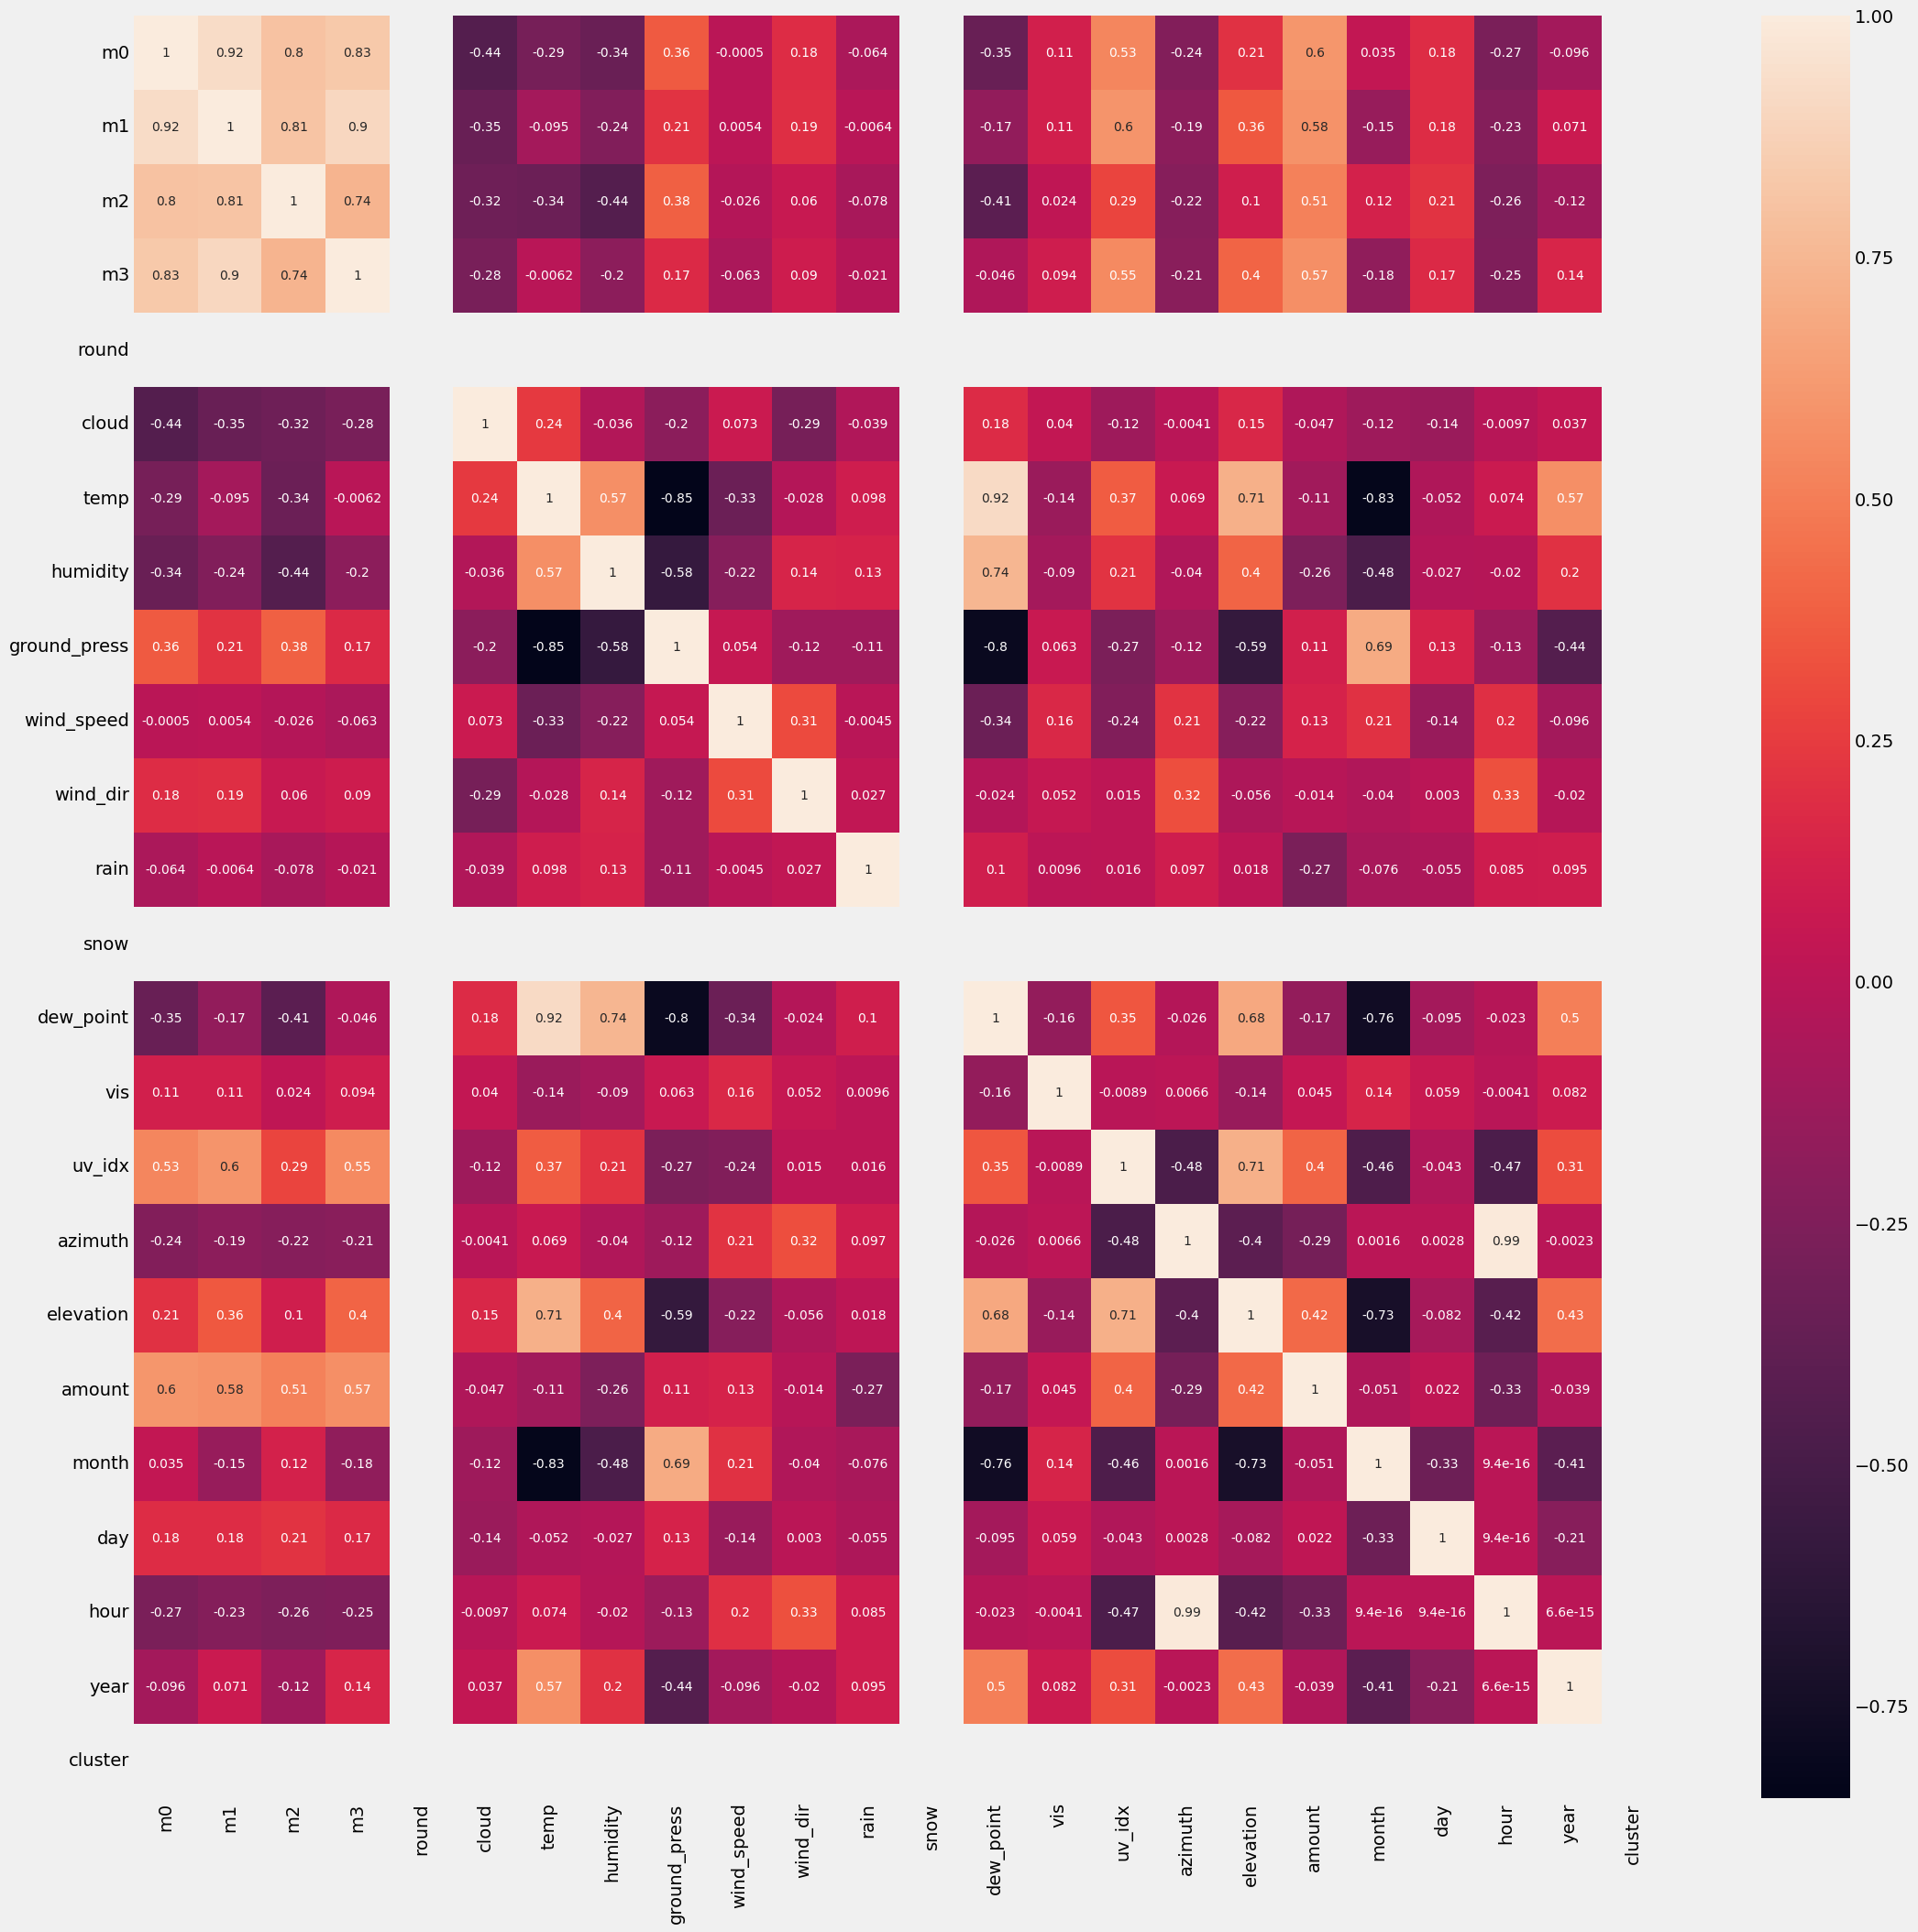

In [21]:
plt.figure(figsize=(24,24))
sns.heatmap(ts_ary.query("cluster==1").corr(),annot=True, annot_kws={"size": 10})

### 클러스터 별로 모델 분리

In [22]:
# 1차 모델링에서 사용할 X데이터셋 생성
# 데이터프레임 이름 읽는 법.
# 변수_몇차모델링_시간분리
# 시간 분리는 (1. 7-10 / 2. 11-14 / 3. 15-19)
# ex) x_df1_1 (x데이터셋, 1차 모델링, 7-10)
x_df1_1 = xy_df_1[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df1_21 = ts_ary[ts_ary["cluster"]==1][["m0","m1","m2","m3","uv_idx","elevation","amount"]]
x_df1_22 = ts_ary[ts_ary["cluster"]==2][["m0","m1","m2","m3","uv_idx","elevation","amount"]]
x_df1_23 = ts_ary[ts_ary["cluster"]==3][["m0","m1","m2","m3","uv_idx","elevation","amount"]]
x_df1_24 = ts_ary[ts_ary["cluster"]==4][["m0","m1","m2","m3","uv_idx","elevation","amount"]]
x_df1_20 = ts_ary[ts_ary["cluster"]==0][["m0","m1","m2","m3","uv_idx","elevation","amount"]]
x_df1_3 = xy_df_3[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df2_1 = xy_df_1.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)
x_df2_21 = ts_ary[ts_ary["cluster"]==1].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster"],axis=1)
x_df2_22 = ts_ary[ts_ary["cluster"]==2].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster"],axis=1)
x_df2_23 = ts_ary[ts_ary["cluster"]==3].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster"],axis=1)
x_df2_24 = ts_ary[ts_ary["cluster"]==4].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster"],axis=1)
x_df2_20 = ts_ary[ts_ary["cluster"]==0].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster"],axis=1)
x_df2_3 = xy_df_3.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)

In [23]:
# 1차 모델링에서 사용할 Y데이터셋 생성
# 표기 법은 X와 동일
# 다만 2차 모델링에서 사용할 Y는 1차 모델링에서 구한 Y_hat을 실제 Y에서 뺀 e임으로 추후에 구해야함
# e = Y - Y_hat
y_df1_1 = xy_df_1["amount"]
y_df1_21 = ts_ary[ts_ary["cluster"]==1]["amount"]
y_df1_22 = ts_ary[ts_ary["cluster"]==2]["amount"]
y_df1_23 = ts_ary[ts_ary["cluster"]==3]["amount"]
y_df1_24 = ts_ary[ts_ary["cluster"]==4]["amount"]
y_df1_20 = ts_ary[ts_ary["cluster"]==0]["amount"]
y_df1_3 = xy_df_3["amount"]

# 모델링1 선형관계 linear or mlp (모델은 바뀔수 있음)

In [25]:
from sklearn.linear_model import LinearRegression

In [27]:
# 1차 모델링 (변수 모델예측량 + 고도 + 자외선 지수)
lm1 = LinearRegression()
lm1.fit(x_df1_21, y_df1_21)
lm2 = LinearRegression()
lm2.fit(x_df1_22, y_df1_22)
lm3 = LinearRegression()
lm3.fit(x_df1_23, y_df1_23)
lm4 = LinearRegression()
lm4.fit(x_df1_24, y_df1_24)
lm5 = LinearRegression()
lm5.fit(x_df1_20, y_df1_20)


LinearRegression()

In [17]:
import joblib
joblib.dump(lm3,"../model/시간3회귀fitting_r2.pkl")

['../model/시간3회귀fitting_r2.pkl']

## 2차 모델링에 사용할 y값을 만들어야함.
## 2차 모델링에서 사용할 y는 Y-Y_hat = e 임.

In [15]:
# 2차 모델링에 사용할 Y 데이터 셋 생성
y_df2_1 = y_df1_1-lm1.predict(x_df1_1)
y_df2_2 = y_df1_2-lm2.predict(x_df1_2)
y_df2_3 = y_df1_3-lm3.predict(x_df1_3)

# 모델링2 잔차에 대하여 fitting (target variable Y = y_df2_1, y_df2_2, y_df2_3)

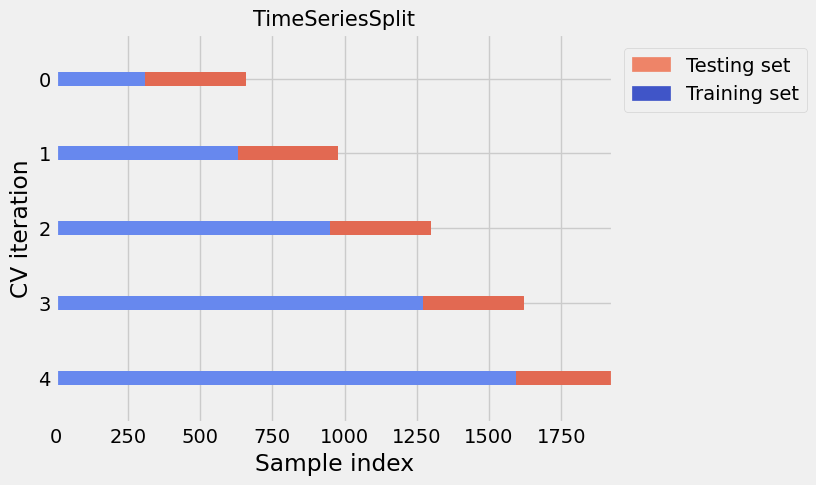

In [22]:
# 1. TimeSeriesSplit 기본
n_split = 5

tscv = TimeSeriesSplit(n_splits=n_split)

plot_cv_indices(tscv, x_df2_1, n_splits=n_split)

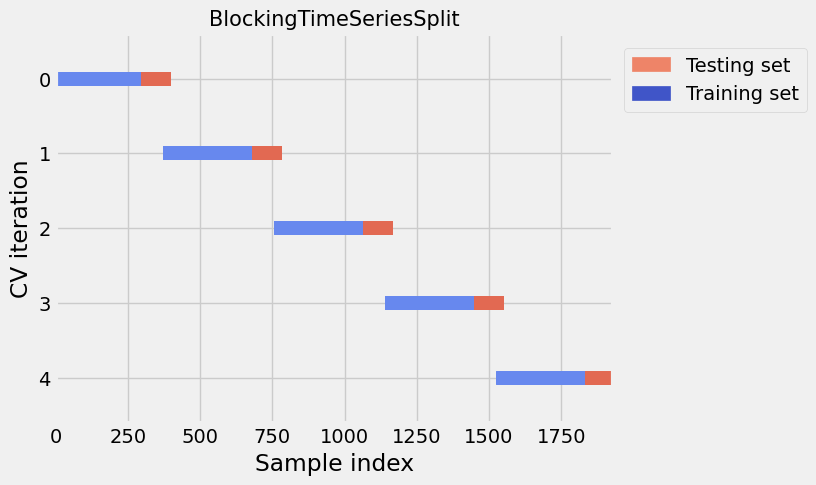

In [23]:
# 2. Blocked TimeSeriesSplit
btscv = BlockingTimeSeriesSplit(n_splits=n_split)
plot_cv_indices(btscv, x_df2_1, n_splits=n_split)

In [ ]:
# 나중에 쓸꺼같음 일단 두셈
score_df = abs(y_pred-y_test)*100/99
score = 0
for i in score_df:
    if i <=6:
        score += y_test * 4
    elif (i <=8) & (i > 6):
        score += y_test * 3
    else:
        score += 0

In [16]:
## optuna 트리모델 설정

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    scores = []
    for i, (train_index, test_index) in enumerate(tscv.split(x_df2_3)):
        x_train, y_train=x_df2_3.iloc[train_index], y_df2_3.iloc[train_index]
        x_test, y_test=x_df2_3.iloc[test_index], y_df2_3.iloc[test_index]

        lgbm_model=LGBMRegressor(**params, boost_from_average=False,
                                  random_state=42)
        lgbm_model.fit(x_train, y_train)

        y_pred=lgbm_model.predict(x_test)
        score = mean_squared_error(y_test,y_pred)


    return score

In [33]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-10-28 18:28:13,265] A new study created in memory with name: no-name-ee4194e8-e58e-496a-8b47-ef9a78393462
[I 2023-10-28 18:28:13,781] Trial 0 finished with value: 138.316535998956 and parameters: {'n_estimators': 231, 'max_depth': 8, 'learning_rate': 0.3742329086468435, 'num_leaves': 20, 'min_child_samples': 55, 'reg_alpha': 0.22454855308367988, 'reg_lambda': 0.9859397588006739}. Best is trial 0 with value: 138.316535998956.
[I 2023-10-28 18:28:14,421] Trial 1 finished with value: 135.0600218313643 and parameters: {'n_estimators': 346, 'max_depth': 14, 'learning_rate': 0.2871385659245117, 'num_leaves': 18, 'min_child_samples': 85, 'reg_alpha': 0.936393259867383, 'reg_lambda': 0.915404467151169}. Best is trial 1 with value: 135.0600218313643.
[I 2023-10-28 18:28:16,419] Trial 2 finished with value: 168.06738632552174 and parameters: {'n_estimators': 1063, 'max_depth': 6, 'learning_rate': 0.4110075530836805, 'num_leaves': 50, 'min_child_samples': 32, 'reg_alpha': 0.20394365521568

In [34]:
print(study.best_value)
print(study.best_params)

93.39396792895573
{'n_estimators': 1327, 'max_depth': 9, 'learning_rate': 0.0007457671983693944, 'num_leaves': 35, 'min_child_samples': 46, 'reg_alpha': 0.2175176486716639, 'reg_lambda': 0.03875040820636515}


# 모델 학습 후 저장

In [35]:
import joblib

In [36]:
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x_df2_3,y_df2_3)
joblib.dump(model,"../model/시간3잔차fitting_r2.pkl")

['../model/시간3잔차fitting_r2.pkl']

# 예측 시작

## 예측하려는 파일을 이제 시간대별 round별로 나눠야함 
## 해당 기능을 수행하는 함수 선언

In [17]:
## test data set 만드는 함수
def make_test_xy(wf,gf):
    gf.columns = ["time","m0","m1","m2","m3","m4"]
    train = pd.merge(gf,wf,on="time")
    train["time"] = pd.to_datetime(train["time"])
    train["month"]=train["time"].dt.month
    train["day"]=train["time"].dt.day
    train["hour"]=train["time"].dt.hour
    
    train_1 = train[(train["hour"]<=10) & (train["hour"]>=7)]
    train_2 = train[(train["hour"]<=14) & (train["hour"]>=11)]
    train_3 = train[(train["hour"]<=19) & (train["hour"]>=15)]
    
    train11 = train_1[["m0","m1","m2","m3","uv_idx","elevation"]]
    train12 = train_2[["m0","m1","m2","m3","uv_idx","elevation"]]
    train13 = train_3[["m0","m1","m2","m3","uv_idx","elevation"]]
    train21 = train_1.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour"],axis=1)
    train22 = train_2.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour"],axis=1)
    train23 = train_3.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour"],axis=1)
    
    return train11,train12,train13,train21,train22,train23

In [18]:
# 예측에 사용할 데이터 셋 불러오기 
x_pred_ori = pd.read_csv("../data/gen_fcst_17_2023-11-01.csv")
x_pred_wf = pd.read_csv("../data/weather_forecasts/wf17_2023-11-01.csv")

In [19]:
# 함수에 넣어서 데이터셋 분리
test11,test12,test13,test21,test22,test23 = make_test_xy(x_pred_wf,x_pred_ori)

In [20]:
import joblib

In [21]:
model11=joblib.load("../model/시간1회귀fitting_r2.pkl")
model12=joblib.load("../model/시간2회귀fitting_r2.pkl")
model13=joblib.load("../model/시간3회귀fitting_r2.pkl")

In [22]:
# 예측 진행 (1차 모델링 y_hat)
y_pred11=model11.predict(test11)
y_pred12=model12.predict(test12)
y_pred13=model13.predict(test13)

In [23]:
model21=joblib.load("../model/시간1잔차fitting_r2.pkl")
model22=joblib.load("../model/시간2잔차fitting_r2.pkl")
model23=joblib.load("../model/시간3잔차fitting_r2.pkl")

In [24]:
y_pred21 = model21.predict(test21)
y_pred22 = model22.predict(test22)
y_pred23 = model23.predict(test23)

In [25]:
result1 = y_pred11+y_pred21
result2 = y_pred12+y_pred22
result3 = y_pred13+y_pred23

In [26]:
result = np.concatenate((result1,result2,result3))
result

array([ 0.47110422,  6.25250684, 23.54657308, 38.86250481, 57.60368876,
       64.18766428, 61.61575198, 56.05627683, 49.67523498, 32.53790328,
       15.77618805,  3.68031387,  1.04987069])